## Config

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
import competitions.pascalvoc as comp;

/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
TRAIN_PATH = cfg.PATHS['datasets']['inputs']['trn_jpg'] 
TEST_PATH = cfg.PATHS['datasets']['inputs']['tst_jpg'] 
comp.make_metadata_file()
meta = utils.files.load_json(cfg.METADATA_PATH)

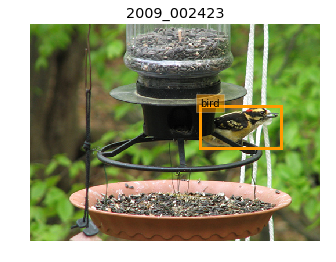

In [3]:
# View images
fpaths,fnames = utils.files.get_paths_to_files(TRAIN_PATH, strip_ext=True)
idx = random.randint(0, len(fpaths))
img = utils.imgs.load_img_as_arr(fpaths[idx])
bboxes =meta['imgs'][fnames[idx]]['bboxes']
title = meta['imgs'][fnames[idx]]['img_id']
utils.imgs.plot_img_w_bboxes(img, bboxes, title)

In [4]:
HARDWARE_CONFIG = {
    'hostname': socket.gethostname(),
    'random_seed': 3,
    'gpu_device':0
}
torch.cuda.set_device(HARDWARE_CONFIG['gpu_device'])
cudnn.benchmark = True

DATA_CONFIG = {
    'img_rescale': 256,
    'dset_fold': 'fold1',
    'n_classes': len(cfg.LABEL_NAMES)
}

TRAIN_CONFIG = {
    'initial_lr': 1e-3,
    'weight_decay': 5e-4,
    'n_epochs': 100,
    'n_cycles': 9,
    'early_stop_metric': metric.Loss().name,
    'max_patience': 20,
    'batch_size': 16,
    'threshold': 0.5,
    'save_weights_cadence': 1, #every epoch
    'lr_schedule': {50:1e-4}
}
OTHER_CONFIG = {}

TRANSFORMS = {
    c.TRAIN: torchsample.transforms.Compose([
        data_aug.SSDAugmentation()
    ]),
    c.VAL: torchsample.transforms.Compose([
        data_aug.SSDAugmentation()
    ]),
    c.TEST: None,
    c.TARGET: torchsample.transforms.Compose([
        data_aug.BBoxTransform(cfg.LABEL_TO_IDX)
    ]),
}

## Data

In [5]:
fpaths,fnames = utils.files.get_paths_to_files(TRAIN_PATH)
val_size = math.floor(len(fnames)*.15)
fold = data_folds.make_fold(DATA_CONFIG['dset_fold'], TRAIN_PATH, TEST_PATH,
                             cfg.PATHS['folds'], val_size, shuffle=True)
print("total", len(fpaths), "val",len(fold['val']), 'trn',len(fold['trn']))

total 17125 val 2568 trn 14557


In [6]:
SAMPLE = 1000000
fold = data_folds.load_data_fold(cfg.PATHS['folds'], DATA_CONFIG['dset_fold'])
trn_fpaths = data_folds.get_fpaths_from_fold(fold, c.TRAIN, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)[:SAMPLE]
val_fpaths = data_folds.get_fpaths_from_fold(fold, c.VAL, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)
tst_fpaths = data_folds.get_fpaths_from_fold(fold, c.TEST, TEST_PATH, postfix=c.JPG_EXT)

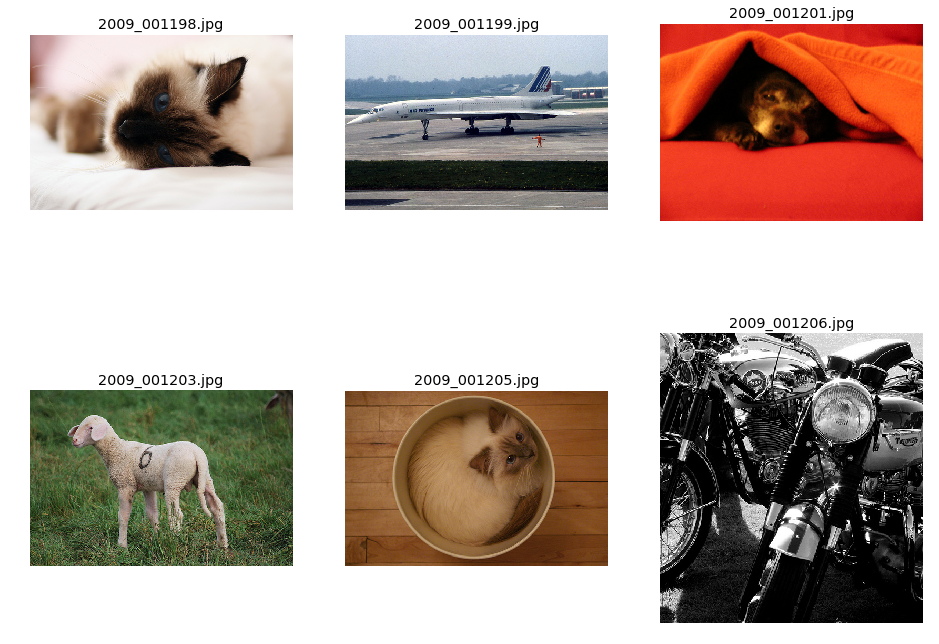

In [7]:
utils.imgs.plot_samples_from_dir(TRAIN_PATH, shuffle=True)

In [8]:
trn_dataset = datasets.datasets.ObjDetectDataset(TRAIN_PATH, fold[c.TRAIN], meta, 
                                                 transform=TRANSFORMS[c.TRAIN], 
                                                 target_transform=TRANSFORMS[c.TARGET])
val_dataset = datasets.datasets.ObjDetectDataset(TRAIN_PATH, fold[c.VAL], meta, 
                                                 transform=TRANSFORMS[c.VAL], 
                                                 target_transform=TRANSFORMS[c.TARGET])
tst_dataset = datasets.datasets.ObjDetectDataset(TRAIN_PATH, fold[c.VAL], meta, 
                                                 transform=TRANSFORMS[c.TEST], 
                                                 target_transform=TRANSFORMS[c.TARGET])
trn_loader = torch.utils.data.DataLoader(trn_dataset, TRAIN_CONFIG['batch_size'], 
                                         shuffle=True, num_workers=4, pin_memory=True,
                                         collate_fn=data_loaders.detection_collate)
val_loader = torch.utils.data.DataLoader(val_dataset, TRAIN_CONFIG['batch_size'], 
                                         shuffle=False, num_workers=2, pin_memory=True,
                                         collate_fn=data_loaders.detection_collate)
tst_loader = torch.utils.data.DataLoader(val_dataset, TRAIN_CONFIG['batch_size'], 
                                         shuffle=False, num_workers=2, pin_memory=True,
                                         collate_fn=data_loaders.detection_collate)

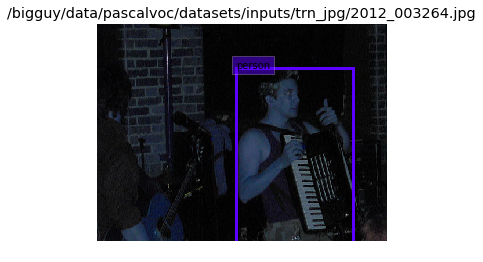

In [9]:
idx = random.randint(0, len(trn_dataset))
utils.imgs.plot_img_w_bboxes(trn_dataset.get_image(idx), 
                             trn_dataset.get_bboxes(idx), 
                             trn_dataset.get_fpath(idx))

In [10]:
img,targ = next(iter(trn_dataset))
img.size(), targ, type(targ)

(torch.Size([3, 300, 300]),
 array([[  0.47419355,   0.75636364,   0.73870968,   0.99272727,  11.        ]]),
 numpy.ndarray)

In [11]:
img,targ = next(iter(tst_dataset))
img.size(), targ, type(targ)

(torch.Size([3, 321, 500]),
 [[0.468, 0.4735202492211838, 0.602, 0.9003115264797508, 14]],
 list)

In [12]:
img,targ = next(iter(trn_loader))
img.size(), len(targ), targ[0]

(torch.Size([16, 3, 300, 300]), 16, 
  0.0085  0.2296  0.6170  0.7481  9.0000
  0.8085  0.7074  0.9404  0.8926  2.0000
  0.3362  0.5074  0.4553  0.6852  2.0000
  0.4936  0.7111  0.6383  0.9074  2.0000
  0.6596  0.5407  0.8468  0.6889  2.0000
 [torch.FloatTensor of size 5x5])

In [13]:
from models.ssd import ssd
from models.ssd.multibox_loss import MultiBoxLoss

version = 'v2'
basenet = 'vgg16_reducedfc.pth'
jaccard_threshold = 0.5
batch_size = 16
num_workers = 2
iterations = 120000
start_iter = 0
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
log_iters = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
ssd_dim = 300
means = (104, 117, 123)
num_classes = len(cfg.LABEL_NAMES) + 1
accum_batch_size = 32
iter_size = accum_batch_size / batch_size
max_iter = 120000
stepvalues = (80000, 100000, 120000)


net = ssd.build_ssd('train', 300, num_classes)

# Pretrained VGG
vgg_weights_fpath = torch.load(os.path.join(
    cfg.PATHS['project'], 'pretrained', basenet))
print(vgg_weights_fpath)
net.vgg.load_state_dict(vgg_weights_fpath)

net = net.cuda()

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform(m.weight.data)
        m.bias.data.zero_()


net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=momentum, 
                      weight_decay=weight_decay)
criterion = MultiBoxLoss(
    num_classes, 0.5, True, 0, True, 
    3, 0.5, False, True)

OrderedDict([('0.weight', 
(0 ,0 ,.,.) = 
  0.4295  0.3735 -0.0614
  0.2748  0.0387 -0.3672
 -0.0575 -0.2622 -0.3501

(0 ,1 ,.,.) = 
  0.5504  0.4401 -0.0814
  0.3457  0.0406 -0.4535
 -0.0586 -0.3307 -0.4850

(0 ,2 ,.,.) = 
  0.4800  0.4085 -0.0651
  0.3105  0.0502 -0.4034
 -0.0509 -0.2852 -0.4185
     ⋮ 

(1 ,0 ,.,.) = 
  0.1173  0.1621  0.1357
  0.1484  0.2023  0.1617
  0.1293  0.1716  0.1387

(1 ,1 ,.,.) = 
  0.0209  0.0473  0.0419
  0.0310  0.0658  0.0463
  0.0317  0.0547  0.0423

(1 ,2 ,.,.) = 
 -0.1727 -0.1704 -0.1544
 -0.1876 -0.1776 -0.1744
 -0.1660 -0.1667 -0.1570
     ⋮ 

(2 ,0 ,.,.) = 
  0.0340  0.0017 -0.1157
  0.1616  0.1564 -0.0899
  0.0129  0.0001 -0.1253

(2 ,1 ,.,.) = 
  0.0988  0.0514 -0.1018
  0.2408  0.2203 -0.0667
  0.0760  0.0487 -0.1121

(2 ,2 ,.,.) = 
  0.0376 -0.0050 -0.1380
  0.1666  0.1512 -0.1098
  0.0156 -0.0080 -0.1491
...   
     ⋮ 

(61,0 ,.,.) = 
 -0.1322 -0.1482 -0.1402
 -0.1143 -0.0520 -0.1459
 -0.1414 -0.1227 -0.1531

(61,1 ,.,.) = 
 -0.0848 -0.0988 

In [14]:
im, targ = next(iter(trn_loader))
im = Variable(im.cuda())
targ = [Variable(anno.cuda(), volatile=True) for anno in targ]

In [15]:
out = net(im)

In [16]:
out[0].size(), out[1].size(), out[2].size()

(torch.Size([16, 8732, 4]), torch.Size([16, 8732, 21]), torch.Size([8732, 4]))

In [17]:
loss_l, loss_c = criterion(out, targ)

/home/bfortuner/anaconda3/lib/python3.6/site-packages/torch/autograd/_functions/tensor.py:450: UserWarning: mask is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return tensor.masked_fill_(mask, value)


In [18]:
loss_l, loss_c

(Variable containing:
  2.8186
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  23.4308
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [ ]:
def train(net, loader):
    net.train()
    loc_loss = 0  # epoch
    conf_loss = 0
    epoch = 0
    epoch_size = len(loader.dataset) // batch_size
    step_index = 0
    batch_iterator = None
    for iteration in range(start_iter, max_iter):
        if (not batch_iterator) or (iteration % epoch_size == 0):
            # create batch iterator
            batch_iterator = iter(loader)
        if iteration in stepvalues:
            step_index += 1
            adjust_learning_rate(optimizer, gamma, step_index)
            loc_loss = 0
            conf_loss = 0
            epoch += 1

        # load train data
        images, targets = next(batch_iterator)
        images = Variable(images.cuda())
        targets = [Variable(anno.cuda(), volatile=True) for anno in targets]

        t0 = time.time()
        out = net(images)
        optimizer.zero_grad()
        loss_l, loss_c = criterion(out, targets)
        loss = loss_l + loss_c
        loss.backward()
        optimizer.step()
        t1 = time.time()
        loc_loss += loss_l.data[0]
        conf_loss += loss_c.data[0]
        if iteration % 10 == 0:
            print('Timer: %.4f sec.' % (t1 - t0))
            print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (
                loss.data[0]), end=' ')

## Train

In [ ]:
train(net, trn_loader)

/home/bfortuner/anaconda3/lib/python3.6/site-packages/torch/autograd/_functions/tensor.py:450: UserWarning: mask is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return tensor.masked_fill_(mask, value)


Timer: 1.8322 sec.
iter 0 || Loss: 26.5132 || Timer: 0.1119 sec.
iter 10 || Loss: 15.4046 || Timer: 0.1120 sec.
iter 20 || Loss: 14.3416 || Timer: 0.1112 sec.
iter 30 || Loss: 14.4692 || Timer: 0.1107 sec.
iter 40 || Loss: 12.8727 || Timer: 0.1111 sec.
iter 50 || Loss: 10.9500 || Timer: 0.1124 sec.
iter 60 || Loss: 12.5562 || Timer: 0.1116 sec.
iter 70 || Loss: 13.7507 || Timer: 0.1116 sec.
iter 80 || Loss: 11.4632 || Timer: 0.1127 sec.
iter 90 || Loss: 13.4541 || Timer: 0.1115 sec.
iter 100 || Loss: 9.8343 || Timer: 0.1128 sec.
iter 110 || Loss: 12.7027 || Timer: 0.1122 sec.
iter 120 || Loss: 14.6780 || Timer: 0.1109 sec.
iter 130 || Loss: 9.4034 || Timer: 0.1115 sec.
iter 140 || Loss: 11.6642 || Timer: 0.1126 sec.
iter 150 || Loss: 11.3647 || Timer: 0.1116 sec.
iter 160 || Loss: 10.4012 || Timer: 0.1127 sec.
iter 170 || Loss: 14.8395 || Timer: 0.1148 sec.
iter 180 || Loss: 13.1009 || Timer: 0.1116 sec.
iter 190 || Loss: 10.0826 || Timer: 0.1119 sec.
iter 200 || Loss: 9.6041 || Timer:

iter 1700 || Loss: 14.7826 || Timer: 0.1123 sec.
iter 1710 || Loss: 9.0823 || Timer: 0.1122 sec.
iter 1720 || Loss: 7.5129 || Timer: 0.1114 sec.
iter 1730 || Loss: 7.9424 || Timer: 0.1117 sec.
iter 1740 || Loss: 6.7857 || Timer: 0.1126 sec.
iter 1750 || Loss: 7.7179 || Timer: 0.1106 sec.
iter 1760 || Loss: 7.7900 || Timer: 0.1128 sec.
iter 1770 || Loss: 6.6776 || Timer: 0.1109 sec.
iter 1780 || Loss: 7.2789 || Timer: 0.1110 sec.
iter 1790 || Loss: 10.4227 || Timer: 0.1127 sec.
iter 1800 || Loss: 7.3598 || Timer: 0.1117 sec.
iter 1810 || Loss: 7.4169 || Timer: 0.1148 sec.
iter 1820 || Loss: 8.5312 || Timer: 0.1119 sec.
iter 1830 || Loss: 6.3751 || Timer: 0.1118 sec.
iter 1840 || Loss: 6.9045 || Timer: 0.1140 sec.
iter 1850 || Loss: 5.9851 || Timer: 0.1110 sec.
iter 1860 || Loss: 6.7064 || Timer: 0.1113 sec.
iter 1870 || Loss: 5.8389 || Timer: 0.1128 sec.
iter 1880 || Loss: 8.0897 || Timer: 0.1116 sec.
iter 1890 || Loss: 7.2899 || Timer: 0.1124 sec.
iter 1900 || Loss: 7.6356 || Timer: 0.

In [ ]:
# Load existing weights (optional)
experiment_name = 'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd1e-05-bs32-fold5K-id767AD'
epoch = 30
exp_utils.load_weights_by_exp_and_epoch(model, experiment_name, epoch)

In [ ]:
# Initialize trainer
criterion = F.binary_cross_entropy
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                       TRAIN_CONFIG['initial_lr'], weight_decay=TRAIN_CONFIG['weight_decay'])
lr_adjuster = learning_rates.ScheduledLR(TRAIN_CONFIG['initial_lr'], 'epoch', 
                                         TRAIN_CONFIG['lr_schedule'])
trainer = trainers.Trainer(criterion, criterion, optimizer, lr_adjuster)

In [ ]:
# Experiment config
NEW_EXP_NAME = 'Baseline'
RESUME_EXP_NAME = None #'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd0.0005-bs64-fold4K-id84E8D'
if not RESUME_EXP_NAME:
    EXP_NAME_ARGS = [utils.general.get_class_name(model), 
                    utils.general.get_class_name(optimizer), 
                    utils.general.get_class_name(lr_adjuster),
                    'img'+str(DATA_CONFIG['img_rescale']),
                    'lr'+str(TRAIN_CONFIG['initial_lr']),
                    'wd'+str(TRAIN_CONFIG['weight_decay']),
                    'bs'+str(TRAIN_CONFIG['batch_size']),
                    str(DATA_CONFIG['dset_fold'])]
    EXPERIMENT_NAME = exp_utils.generate_display_name(NEW_EXP_NAME, EXP_NAME_ARGS)
    METRICS = [metric.Loss(), metric.Accuracy(), metric.F2Score()]
    AUX_METRICS = [metric.AuxiliaryMetric('LearningRate', 'lr'), 
                   metric.AuxiliaryMetric('SystemMemory', 'mb')]
    VISUALIZERS = [Viz(EXPERIMENT_NAME)]

    EXP_CONFIG = {
        'name': EXPERIMENT_NAME,
        'parent_dir': cfg.PATHS['experiments'],
        'metrics': METRICS,
        'aux_metrics': AUX_METRICS,
        'visualizers': VISUALIZERS,
        'data': DATA_CONFIG,
        'training': TRAIN_CONFIG,
        'other': OTHER_CONFIG,
        'transforms': TRANSFORMS[c.TRAIN],
        'hardware': HARDWARE_CONFIG,
        'model': model,
        'optimizer': optimizer,
        'lr_adjuster': lr_adjuster,
        'criterion': criterion
    }

In [ ]:
# Resume experiment
exp = Experiment(RESUME_EXP_NAME, cfg.PATHS['experiments'])
exp.resume(verbose=True)
trainer = trainers.Trainer(criterion, criterion, exp.optim, lr_adjuster)

In [ ]:
# Create new experiment
exp = Experiment(EXP_CONFIG['name'], cfg.PATHS['experiments'])
exp.init(EXP_CONFIG)
print(exp.name)

In [ ]:
exp.train(trainer, trn_loader, val_loader)

## Predict

In [ ]:
# Load model from exp epoch
exp.load_model_state(epoch=10)
model = exp.model

In [ ]:
# OR load custom model weights
exp_name = RESUME_EXP_NAME
w_path = os.path.join(cfg.PATHS['experiments'], exp_name, 'weights', 'weights-30.th')
models.utils.load_weights(model, w_path)

In [ ]:
%time val_probs = predictions.get_probabilities(model, val_loader)

In [ ]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.VAL)
_ = predictions.save_or_append_pred_to_file(pred_fpath, val_probs)

In [ ]:
thresh = TRAIN_CONFIG['threshold']
acc = metric_utils.get_accuracy(val_probs > thresh, val_targs)
f2 = metric_utils.get_metric_in_blocks(val_probs > thresh, val_targs, 
                                       1000, metric_utils.get_f2_score)
loss = metric_utils.get_cross_entropy_loss(val_probs, val_targs)
print("Acc",acc,"F2",f2,"BCE",loss)
utils.imgs.plot_sample_preds(val_fpaths, val_probs > 0.5, val_targs, 
                             dogscats.LABEL_NAMES)

In [ ]:
%time tst_probs = predictions.get_probabilities(model, tst_loader)

In [ ]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.TEST)
_ = predictions.save_or_append_pred_to_file(pred_fpath, tst_probs)
tst_probs = predictions.load_pred(pred_fpath, numpy=True)
utils.imgs.plot_sample_preds(tst_fpaths, tst_probs > thresh, 
                             None, dogscats.LABEL_NAMES)

## Ensemble

In [ ]:
member_fpaths = predictions.list_local_preds(dset=c.TEST, fnames_only=False)
member_fpaths

In [ ]:
ens_fpath = ensembles.get_ensemble_fpath(basename='my_exp', dset=c.TEST)
_ = ensembles.ens_prediction_files(
    ens_fpath, member_fpaths, block_size=1000, method=c.MEAN)
ens_probs = predictions.load_pred(ens_fpath, numpy=True)

## Submit

In [ ]:
tst_probs = predictions.load_pred(pred_fpath, numpy=True)

In [ ]:
sub_fpath = submissions.get_sub_path_from_pred_path(pred_fpath)
fnames = utils.files.get_fnames_from_fpaths(tst_fpaths)
sub_ids = [f.split('.')[0] for f in fnames]
tst_probs = np.clip(tst_probs, .005, .995) #good for BCE problems
submissions.make_preds_submission(sub_fpath, sub_ids, 
                                  np.expand_dims(tst_probs[:,1],1), 
                                  dogscats.SUB_HEADER)

In [ ]:
# https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
# Public Leaderboard .0566, Top 8%
# kg submit -m 'my sub' -c dogs-vs-cats-redux-kernels-edition -v -u USERNAME -p PASSWORD planet_tst.csv
FileLink(sub_fpath)

## Evaluate

In [ ]:
# Review Experiment
exp_name = 'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd0.0005-bs64-fold4K-id84E8D'
exp = Experiment(exp_name, cfg.PATHS['experiments'])
exp.review(verbose=False)
exp.history.plot()

In [ ]:
# Load Pred
fname = 'my_exp_val.bc'
thresh = TRAIN_CONFIG['threshold']
probs = predictions.load_pred(os.path.join(cfg.PATHS['predictions'], fname))
preds = predictions.get_predictions(probs, thresh)

In [ ]:
# View preds, probs, and targets
eval_df = evaluate.get_evaluate_df(preds, probs, val_targs, 
                                   val_fpaths, dogscats.LABEL_NAMES)
eval_df[:5]

In [ ]:
# View preds by label
LABEL = 'dog'
dog_preds_by_targ = evaluate.get_preds_by_target_label(
    eval_df, LABEL, condensed=False)
dog_preds_by_pred = evaluate.get_preds_by_predicted_label(
    eval_df, LABEL, condensed=False)
dog_preds_by_targ[:5]

In [ ]:
# View preds by probability

# Confident dogs and right (TP)
confident_dogs_tp = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 1, p_min=0.9, p_max=1.0)
# Confident dogs and wrong (FP)
confident_dogs_fp = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 0, p_min=0.9, p_max=1.0)
# Unconfident dogs and right (TN)
unconfident_dogs_tn = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 0, p_min=0.0, p_max=0.1)
# Unconfident dogs and wrong (FN)
unconfident_dogs_fn = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 1, p_min=0.0, p_max=0.1)

# Annotation errors?
evaluate.plot_predictions(unconfident_dogs_fn, dogscats.LABEL_NAMES)
unconfident_dogs_fn

In [ ]:
# View predictions and probabilities
evaluate.plot_predictions(eval_df, dogscats.LABEL_NAMES)

In [ ]:
# Confusion Matrix
evaluate.plot_label_level_cms(eval_df, dogscats.LABEL_NAMES)

In [ ]:
# Plot ROC Curve
evaluate.plot_roc_curve(np.array(probs), val_targs)